# Vanilla CNN Approach

## Data Loading and Preprocessing

In [1]:
from tensorflow.keras.utils import image_dataset_from_directory # type: ignore
import tensorflow as tf

2025-05-08 11:36:05.839158: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-08 11:36:05.919495: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746700565.961080  154433 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746700565.970194  154433 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746700566.057494  154433 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# Loading the dataset using tensorflow's image_dataset_from_directory function
image_size = (256, 256)
train_dataset = image_dataset_from_directory(
    "dataset/train",
    label_mode="categorical",
    image_size=image_size,
    batch_size=32,
    shuffle=True,
    seed=123,
)

test_dataset = image_dataset_from_directory(
    "dataset/test",
    label_mode="categorical",
    image_size=image_size,
    batch_size=32,
    shuffle=False,
    seed=123,
)

val_dataset = image_dataset_from_directory(
    "dataset/val",
    label_mode="categorical",
    image_size=image_size,
    batch_size=32,
    shuffle=False,
    seed=123,
)


Found 1336 files belonging to 2 classes.


I0000 00:00:1746700571.479002  154433 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4396 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 238 files belonging to 2 classes.
Found 234 files belonging to 2 classes.


In [3]:
# Visualizing samples from the dataset
import matplotlib.pyplot as plt
import numpy as np
from helpers import plot_sample_images, get_sample_images

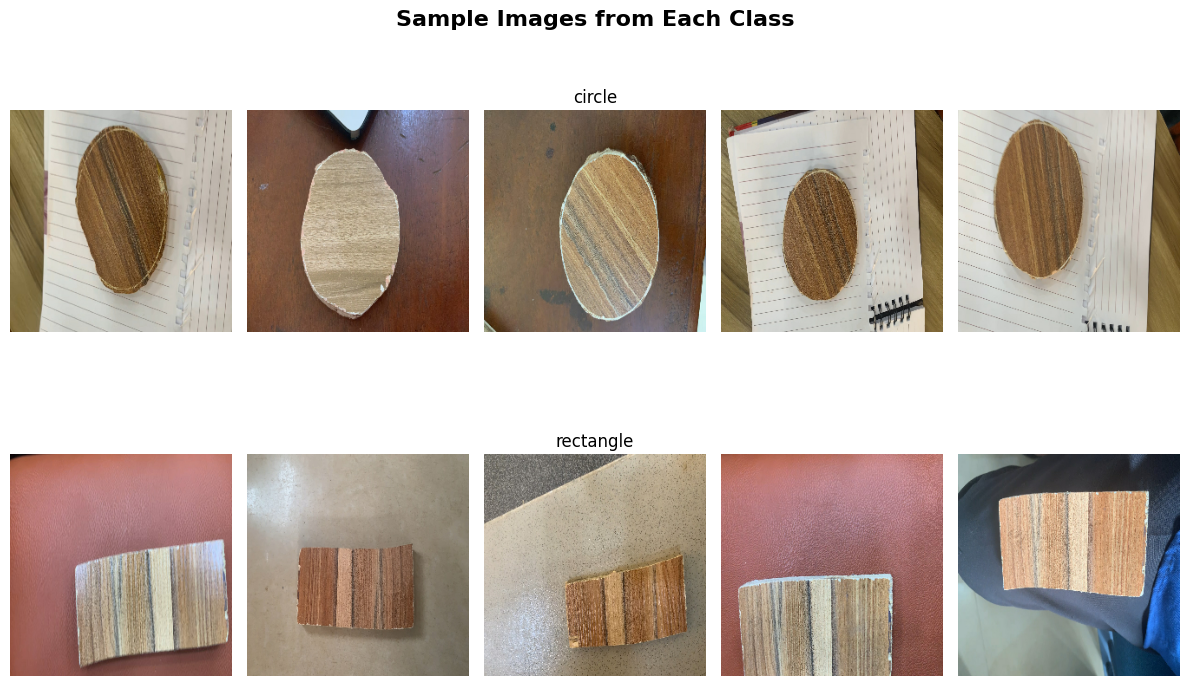

In [4]:
class_names = train_dataset.class_names
# Get samples for each class
sample_images = get_sample_images(train_dataset, class_names, 5)
# Plot the sample images
plot_sample_images(class_names, sample_images, filename="vanilla_cnn_sample_images.png")

## Model Creation and Training

In [ ]:
# Function for creating CNN architecture
def create_vanilla_cnn(input_shape: tuple) -> tf.keras.Sequential:
    model = tf.keras.Sequential()
    # Add an input layer
    model.add(tf.keras.layers.Input(shape=input_shape))

    # Convolutional blocks
    ## Block 1
    model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding="same", activation="relu"))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))
    ## Block 2
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))

    # Global Average Pooling layer
    model.add(tf.keras.layers.GlobalAveragePooling2D())

    # Dense (fully connected) blocks
    model.add(tf.keras.layers.Dense(units=16, kernel_regularizer="l2", activation="relu"))
    model.add(tf.keras.layers.Dropout(0.3))

    # Output layer
    model.add(tf.keras.layers.Dense(units=len(class_names), activation="softmax"))

    return model

In [6]:
vanilla_cnn = create_vanilla_cnn(
    input_shape=(image_size[0], image_size[1], 3)
)
vanilla_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,210 (24.26 KB)

 Trainable params: 6,210 (24.26 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
vanilla_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5),
    tf.keras.callbacks.ModelCheckpoint(filepath="./models/best_vanillaCNN.keras", monitor="val_accuracy", save_best_only=True)
]

In [8]:
# --------------- Training the model --------------- #
vanillaCNN_history = vanilla_cnn.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=callbacks,
)

Epoch 1/30


I0000 00:00:1746701194.648933  154945 service.cc:152] XLA service 0x7fc6a400c680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746701194.649034  154945 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-05-08 11:46:34.808009: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746701194.964374  154945 cuda_dnn.cc:529] Loaded cuDNN version 90501


 3/42 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.4948 - loss: 27.8292

I0000 00:00:1746701199.489616  154945 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 183ms/step - accuracy: 0.4961 - loss: 12.7246 - val_accuracy: 0.6368 - val_loss: 1.0507
Epoch 2/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.5627 - loss: 1.3638 - val_accuracy: 0.7436 - val_loss: 0.6967
Epoch 3/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.6909 - loss: 0.8181 - val_accuracy: 0.7179 - val_loss: 0.6269
Epoch 4/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.7147 - loss: 0.7394 - val_accuracy: 0.8120 - val_loss: 0.5983
Epoch 5/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.7547 - loss: 0.6581 - val_accuracy: 0.8675 - val_loss: 0.5047
Epoch 6/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.8254 - loss: 0.5583 - val_accuracy: 0.8675 - val_loss: 0.4571
Epoch 7/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8264 - loss: 0.5478 - val_accuracy: 0.8974 - val_loss: 0.4715
Epoch 8/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8485 - loss: 0.5081 - val_accuracy: 0.9017 - val_loss:

## Model Evaluation

In [13]:
from helpers import plot_training_curves, show_evaluation_report

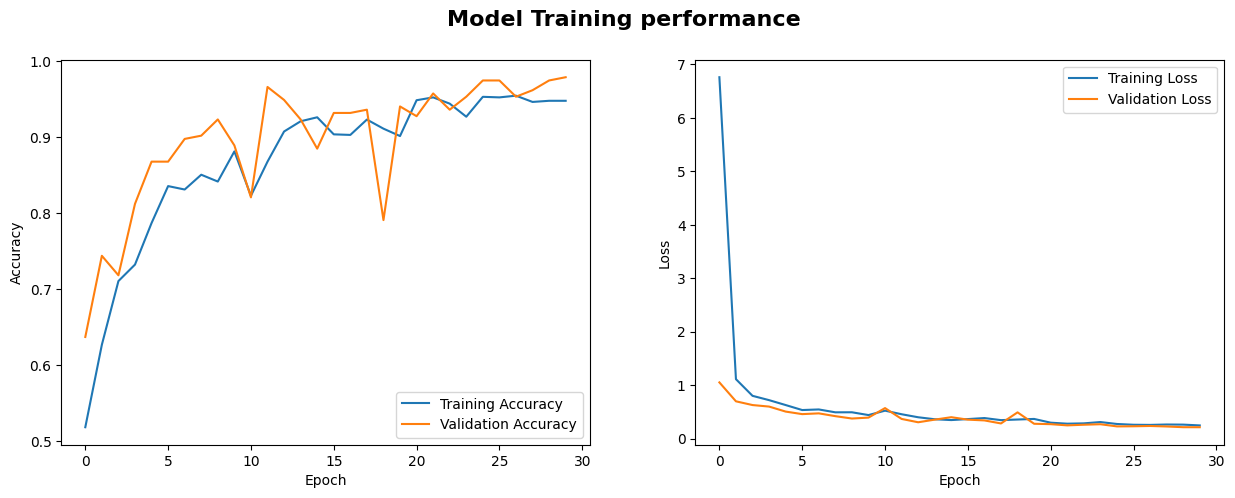

In [ ]:
plot_training_curves(
    vanillaCNN_history.history,
    filename="vanilla_cnn_training_curves.png"
)

In [16]:
# Load the model with the best validation accuracy
best_vanilla_cnn = tf.keras.models.load_model("./models/best_vanillaCNN.keras")

2025-05-08 11:51:33.482669: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step


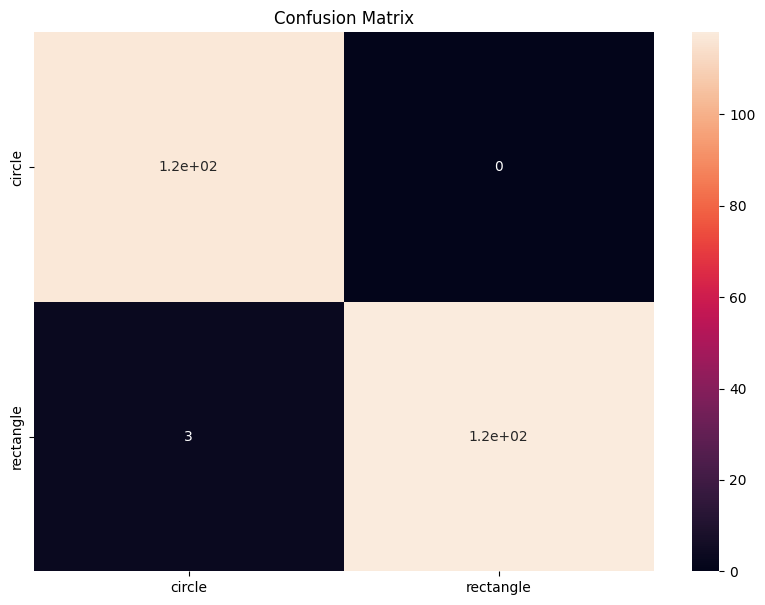



Classification Report:

              precision    recall  f1-score   support

      circle       0.97      1.00      0.99       117
   rectangle       1.00      0.98      0.99       121

    accuracy                           0.99       238
   macro avg       0.99      0.99      0.99       238
weighted avg       0.99      0.99      0.99       238



Model Accuracy: 0.99


In [17]:
# Evaluate the model on the test dataset
show_evaluation_report(best_vanilla_cnn, [test_dataset], filename="vanilla_cnn_training_curves.png")